In [1]:
import glob

from torch.nn.functional import interpolate
from torch.utils.data import DataLoader

from inpainting import transforms
from inpainting.load import MergeDataset, SequenceDataset
from inpainting.utils import dilate_mask, annotation_to_mask, flow_tensor_to_image_tensor, tensor_to_pil_image

In [2]:
images_dataset = SequenceDataset(
    list(glob.glob(f'../data/interim/DAVIS/JPEGImages/480p/tennis')),
    'image',
    sequence_length=2,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)
masks_dataset = SequenceDataset(
    list(glob.glob(f'../data/interim/DAVIS/Annotations/480p/tennis')),
    'annotation',
    sequence_length=2,
    transform=transforms.Compose([
        transforms.Lambda(lambda x: annotation_to_mask(x, object_id=[1, 2])),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: dilate_mask(x, 3, 3))
    ])
)
dataset = MergeDataset([images_dataset, masks_dataset])
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [3]:
images, masks = next(iter(data_loader))
prev_image, curr_image = images
prev_image, curr_image = prev_image.cuda(), curr_image.cuda()

prev_mask, curr_mask = masks
prev_mask, curr_mask = prev_mask.cuda(), curr_mask.cuda()

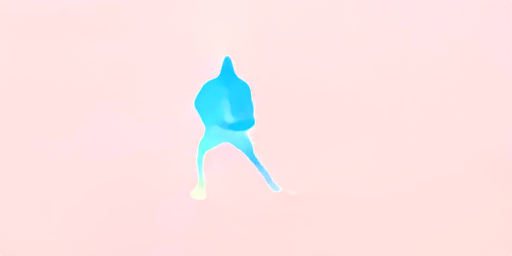

In [4]:
from inpainting.flow.flownet2.model import FlowNet2Model

model = FlowNet2Model('../models/flow/flownet2/FlowNet2_checkpoint.pth.tar').cuda()
flow = model(prev_image, curr_image).detach()
tensor_to_pil_image(flow_tensor_to_image_tensor(flow))

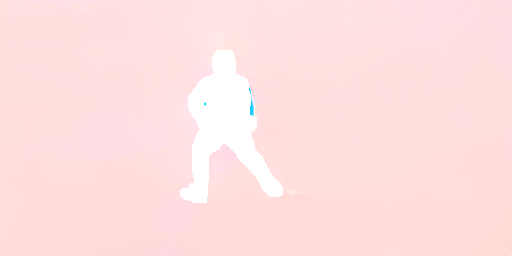

In [5]:
masked_flow = flow * (1 - prev_mask)
tensor_to_pil_image(flow_tensor_to_image_tensor(masked_flow))

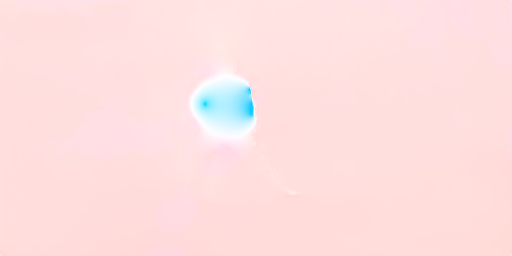

In [6]:
from inpainting.inpainting.kernel_inpainting import Inpainter

algorithm = Inpainter()
result = algorithm(flow, prev_mask)
tensor_to_pil_image(flow_tensor_to_image_tensor(result))

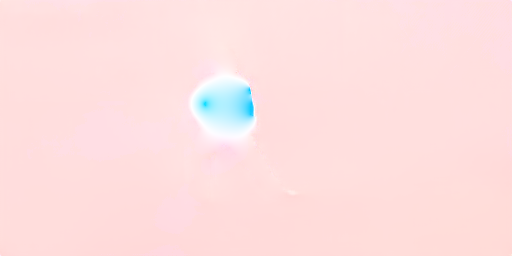

In [7]:
from inpainting.inpainting.region_fill import inpaint

result = inpaint(flow, prev_mask)
tensor_to_pil_image(flow_tensor_to_image_tensor(result))
